# Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from IPython.core.display_functions import display
from PIL import Image, ImageOps
from torchvision.transforms import Compose, Resize, ToTensor
# import cv2 as cv
from collections import deque

import torch.optim as optim
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import os
# from einops import rearrange, reduce, repeat
# from einops.layers.torch import Rearrange, Reduce
# from torchsummary import summary
# from torch.distributions import Categorical

In [2]:
def generate_cropped_im(im, cropped_dims):
    h_shift = 10
    s_shift = 10
    v_shift = 50
    # generate random crop shifts
    crop_attributes = {}
    cropped_shift = [np.random.randint(0,im.size[0]-cropped_dims[0]),np.random.randint(0,im.size[1]-cropped_dims[1])]
    # cropped_shift = [37,37]
    crop_coords = (cropped_shift[0], cropped_shift[1], cropped_shift[0]+cropped_dims[0], cropped_shift[1]+cropped_dims[1])
    cropped_im = im.crop(crop_coords)
    cropped_im = cropped_im.convert('HSV')
    h, s, v = cropped_im.split()
    h = h.point(lambda p: p + h_shift)
    s = s.point(lambda p: p + s_shift)
    v = v.point(lambda p: p + v_shift)
    cropped_im = Image.merge('HSV', (h, s, v))
    cropped_im = cropped_im.convert('RGB')
    cropped_im_shape = cropped_im.size
    crop_attributes['crop_coords'] = crop_coords
    crop_attributes['cropped_shift'] = cropped_shift
    crop_attributes['cropped_im'] = cropped_im
    crop_attributes['cropped_im_shape'] = cropped_im_shape
    
    return crop_attributes

In [110]:
class Env:
    def __init__(self, fixed_image, moving_image, crop_coords=(37, 37, 74, 74)):
        self.crop_coords = crop_coords
        self.fixed_image = fixed_image
        self.moving_image = moving_image
        self.fixed_x = fixed_image.size[0]
        self.fixed_y = fixed_image.size[1]
        self.crop_x = crop_coords[0]
        self.crop_y = crop_coords[1]
        self.shift_x = 0
        self.shift_y = 0
        self.x_limit = fixed_image.size[0] - moving_image.size[0]
        self.y_limit = fixed_image.size[1] - moving_image.size[1]
        self.env_image = fixed_image.copy()
        self.env_image.paste(moving_image, (0,0))
        self.action_space = 4

#     def reset(self):
#         # move image to a random position
#         print(self.x_limit)
#         self.shift_x = np.random.randint(0, self.x_limit)
#         self.shift_y = np.random.randint(0, self.y_limit)
#         self.env_image = self.fixed_image.copy()
#         self.env_image.paste(self.moving_image, (self.shift_x, self.shift_y))
#         return self.env_image
    
    def reset(self):
        crop_attr = generate_cropped_im(self.fixed_image, [37,37])
        self.crop_coords = crop_attr['crop_coords']
        print(f"Crop coords: {self.crop_coords}")
        self.moving_image = crop_attr['cropped_im']
        self.crop_x = self.crop_coords[0]
        self.crop_y = self.crop_coords[1]
        self.x_limit = self.fixed_image.size[0] - self.moving_image.size[0]
        self.y_limit = self.fixed_image.size[1] - self.moving_image.size[1]
        # move image to a random position
        print(self.x_limit)
        self.shift_x = np.random.randint(0, self.x_limit)
        self.shift_y = np.random.randint(0, self.y_limit)
        self.env_image = self.fixed_image.copy()
        self.env_image.paste(self.moving_image, (self.shift_x, self.shift_y))
        
        return self.env_image

    def check_frame(self, _im):
        _im_shape = _im.size
        _im_shape = [_im_shape[0] - 1, _im_shape[1] - 1]
        # check bottom border
        for i in range(_im_shape[0]):
            px = _im.getpixel((i, 0))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check top border
        for i in range(_im_shape[0]):
            px = _im.getpixel((i, _im_shape[1]))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check left border
        for i in range(_im_shape[1]):
            px = _im.getpixel((0, i))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check right border
        for i in range(_im_shape[1]):
            px = _im.getpixel((_im_shape[0], i))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        return True

    def move_image(self, _x, _y):
        shift_x = int(self.shift_x + _x)
        shift_y = int(self.shift_y + _y)
        # shift_x = _x
        # shift_y = _y
        # check if image can be moved
        reward_bonus = 10
        if shift_x > self.x_limit:
            shift_x = self.x_limit
            reward_bonus -= 10
            # print('x limit reached')
        elif shift_x < 0:
            shift_x = 0
            reward_bonus -= 10
            # print('x limit reached')
        if shift_y > self.y_limit:
            shift_y = self.y_limit
            reward_bonus -= 10
            # print('y limit reached')
        elif shift_y < 0:
            shift_y = 0
            reward_bonus -= 10
            # print('y limit reached')
        if shift_x < 0 or shift_y < 0:
            print(f"Image can't be moved to {shift_x}, {shift_y}")
            return self.env_image, self.get_reward()
        self.shift_x = shift_x
        self.shift_y = shift_y
        env_copy = self.fixed_image.copy()
        env_copy.paste(self.moving_image, (shift_x, shift_y))
        self.env_image = env_copy
        reward = self.get_reward()
        # print(f"shift x {shift_x}, shift y {shift_y}, moved x {_x}, moved y {_y} moved x {self.crop_x}, moved y {self.crop_y}, reward {reward}")
        return env_copy, reward+reward_bonus

    def get_reward(self):
        distance = np.sqrt((self.shift_x - self.crop_x)**2 + (self.shift_y - self.crop_y)**2)
        return -distance

    def get_target(self, shift_x, shift_y):
        _x = self.crop_x - shift_x
        _y = self.crop_y - shift_y
        target_x = 0.5+(_x/(2*self.x_limit))
        target_y = 0.5+(_y/(2*self.y_limit))
        return target_x, target_y

    def get_pred_target(self, pred):
        shift_x = (pred[0]*2-1) * self.x_limit
        shift_y = (pred[1]*2-1) * self.y_limit
        _x = self.crop_x - shift_x
        _y = self.crop_y - shift_y
        pred_target_x = 0.5+(_x/(2*self.x_limit))
        pred_target_y = 0.5+(_y/(2*self.y_limit))
        return pred_target_x, pred_target_y
        # return _x, _y

    def move_image_old(self, x, y):
        # move image using pil
        new_im = self.moving_image.transform(self.moving_image.size, Image.AFFINE, (1, 0, x, 0, 1, y))
        can_move = self.check_frame(new_im)
        if can_move:
            self.moving_image = new_im
            return new_im
        else:
            return self.moving_image

    def step(self, action, amount=1):
        """
        action: 0 = left, 1 = right, 2 = up, 3 = down
        """
        
        x_amount = action[0][0]*self.fixed_image.size[0]
        y_amount = action[0][1]*self.fixed_image.size[1]
        new_im, reward = self.move_image(x_amount, y_amount)

        if reward >= -1:
            reward = (self.fixed_image.size[0] + 100)
            return new_im, reward, True
        else:
            return new_im, (reward+self.fixed_image.size[0]/100), False

In [111]:
def preprocess_data(path, display=True):
    h_shift = 0
    s_shift = 0
    v_shift = 0
    envs = []
    for i, filename in enumerate(os.listdir(path)):
        if filename.endswith(".jpg"):
            if i == 100:
                break
            im = Image.open('/'.join([path, filename]))
            im_shape = im.size
            if im_shape[0] >= 112 and im_shape[1] >= 112:
                im_scale_x = im_shape[0]/112
                im_scale_y = im_shape[1]/112

                scale = 1/2
                im = im.resize((int(im_shape[0]/im_scale_x),int(im_shape[1]/im_scale_y)),Image.ANTIALIAS)
                im_shape = im.size
                im = im.crop((0, 0, 112, 112))
                im_shape = im.size
                cropped_dims = [37, 37]
                crop_attr = generate_cropped_im(im, cropped_dims)
                cropped_im = crop_attr['cropped_im']
                # change cropped image hue
                cropped_im = cropped_im.convert('HSV')
                cropped_im_shape = crop_attr['cropped_im_shape']
                print(f'im_shape: {im_shape}, cropped_im_shape: {cropped_im_shape}')
                crop_coords = crop_attr['crop_coords']

                # red_dot = Image.new('RGB', (10, 10), color = 'red')
                # green_dot = Image.new('RGB', (10, 10), color = 'green')
                env_im = im
                # cropped_im.paste(red_dot, (0,0))
                fixed_x = crop_coords[0]
                fixed_y = crop_coords[1]
                shift_x = im_shape[0] - cropped_im_shape[0]
                shift_y = 0

                fixed = (fixed_x, fixed_y)
                moving = (shift_x, shift_y)

                distance = np.sqrt((fixed[0] - moving[0])**2 + (fixed[1] - moving[1])**2)

                # env_im.paste(cropped_im, (shift_x, shift_y))
                # env_im.paste(green_dot, (fixed_x, fixed_y))
                env = Env(im, cropped_im, crop_coords)
                envs.append(env)
                print(f'image: {path},  distance: {distance}')
                im2 = im.copy()
                if display:
                    plt.imshow(im2)
                    plt.show()
                    plt.imshow(cropped_im)
                    plt.show()
                # resize to imagenet size
                transform = Compose([Resize((112, 112)), ToTensor()])
                x = transform(im)
                x = x.unsqueeze(0) # add batch dim
                x.shape
    return envs

In [112]:
envs = preprocess_data('coffee', display=False)

im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 25.298221281347036
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 37.33630940518894
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 44.654227123532216
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 71.58910531638176
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 67.23094525588644
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 70.40596565632774
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 83.00602387778854
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 86.53323061113575
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 78.16009211867653
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 73.55270219373317
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  dis

/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  app.launch_new_instance()


In [113]:
device = torch.device("cuda")
print(device)

env = envs[1]

cuda


Crop coords: (43, 7, 80, 44)
75
Reward: -57.0701322935211


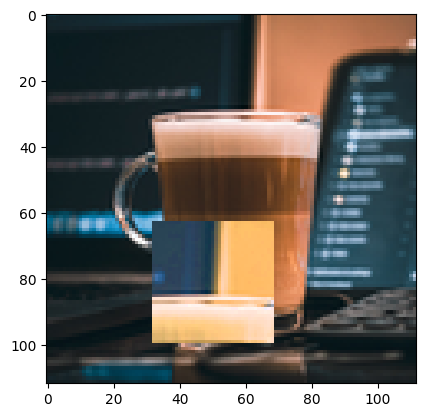

11 -56
10.0


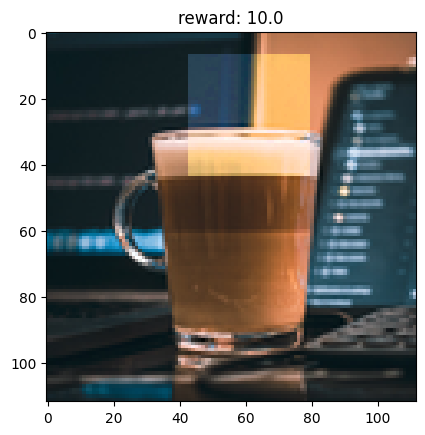

In [114]:
im_b = env.reset()
reward = env.get_reward()
print(f"Reward: {reward}")
plt.imshow(im_b)
plt.show()
# print(f"shift coords: {env.shift_x}, {env.shift_y}")
# print(f"moving coords: {env.crop_x}, {env.crop_y}")
# print(f"diff: {env.crop_x-env.shift_x}, {env.crop_y-env.shift_y}")
targets = env.get_pred_target([0.5+(env.shift_x/(2*env.x_limit)),0.5+(env.shift_y/(2*env.y_limit))])
print(env.crop_x-env.shift_x+0 ,env.crop_y - env.shift_y+0)
im_a, r = env.move_image(env.crop_x-env.shift_x ,env.crop_y - env.shift_y)
print(r)
plt.imshow(im_a)
plt.title(f'reward: {r}')
plt.show()

# utils

In [115]:
import matplotlib.pyplot as plt 
import numpy as np

def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')       
    plt.xlabel('Game')                     
    plt.plot(x, running_avg)
    plt.savefig(filename)

# ddpg_torch

In [116]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor
import numpy as np
import torchvision.transforms as T

# resize = Compose([torch.ToPILImage(),
#                     torch.Resize(112, interpolation=Image.CUBIC),
#                     torch.ToTensor()])

resize = T.Compose([T.ToPILImage(),
                    T.Resize(112, interpolation=Image.CUBIC),
                    T.ToTensor()])

class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.con_bn1 = nn.GroupNorm(16,16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.con_bn2 = nn.GroupNorm(32,32)
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(112))
        convh = conv2d_size_out(conv2d_size_out(112))
        linear_input_size = convw * convh * 32
        self.fc1 = nn.Linear(linear_input_size, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        #self.fc1.weight.data.uniform_(-f1, f1)
        #self.fc1.bias.data.uniform_(-f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        #f2 = 0.002
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        #self.fc2.weight.data.uniform_(-f2, f2)
        #self.fc2.bias.data.uniform_(-f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        f3 = 0.003
        self.q = nn.Linear(self.fc2_dims, 1)
        torch.nn.init.uniform_(self.q.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.q.bias.data, -f3, f3)
        #self.q.weight.data.uniform_(-f3, f3)
        #self.q.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = F.relu(self.con_bn1(self.conv1(state)))
        state_value = self.conv2(state_value)
        state_value = self.con_bn2(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc1(state_value.view(state_value.size(0), -1))
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(torch.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.con_bn1 = nn.GroupNorm(16,16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.con_bn2 = nn.GroupNorm(32,32)
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(112))
        convh = conv2d_size_out(conv2d_size_out(112))
        linear_input_size = convw * convh * 32
        self.fc1 = nn.Linear(linear_input_size, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        #self.fc1.weight.data.uniform_(-f1, f1)
        #self.fc1.bias.data.uniform_(-f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        #f2 = 0.002
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        #self.fc2.weight.data.uniform_(-f2, f2)
        #self.fc2.bias.data.uniform_(-f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #f3 = 0.004
        f3 = 0.003
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        torch.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        #self.mu.weight.data.uniform_(-f3, f3)
        #self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.conv1(state)
        x = self.con_bn1(x)
        x = F.relu(x)
        x = F.relu(self.con_bn2(self.conv2(x)))
        x = self.fc1(x.view(x.size(0), -1))
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = torch.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

def transform_obs(observation):
        observation = np.ascontiguousarray(observation, dtype=np.float32) / 255
        observation = torch.from_numpy(observation)
        observation = resize(observation.T)
        observation = observation.unsqueeze(0)
        return observation

class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma=0.99,
                 n_actions=2, max_size=10000, layer1_size=400,
                 layer2_size=300, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='Actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size,
                                    layer2_size, n_actions=n_actions,
                                    name='Critic')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='TargetActor')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions,
                                           name='TargetCritic')

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1)

    
    

    def choose_action(self, observation):
        self.actor.eval()
        observation = transform_obs(observation)
        
        # observation = torch.tensor(observation, dtype=torch.float).to(self.actor.device)
        mu = self.actor.forward(observation.to(self.actor.device)).to(self.actor.device)
        mu_prime = mu + torch.tensor(self.noise(),
                                 dtype=torch.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)

        reward = torch.tensor(reward, dtype=torch.float).to(self.critic.device)
        done = torch.tensor(done).to(self.critic.device)
        new_state = torch.tensor(new_state, dtype=torch.float).to(self.critic.device)
        action = torch.tensor(action, dtype=torch.float).to(self.critic.device)
        state = torch.tensor(state, dtype=torch.float).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = torch.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)

        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = torch.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

        """
        #Verify that the copy assignment worked correctly
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(target_critic_params)
        actor_state_dict = dict(target_actor_params)
        print('\nActor Networks', tau)
        for name, param in self.actor.named_parameters():
            print(name, torch.equal(param, actor_state_dict[name]))
        print('\nCritic Networks', tau)
        for name, param in self.critic.named_parameters():
            print(name, torch.equal(param, critic_state_dict[name]))
        input()
        """
    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def check_actor_params(self):
        current_actor_params = self.actor.named_parameters()
        current_actor_dict = dict(current_actor_params)
        original_actor_dict = dict(self.original_actor.named_parameters())
        original_critic_dict = dict(self.original_critic.named_parameters())
        current_critic_params = self.critic.named_parameters()
        current_critic_dict = dict(current_critic_params)
        print('Checking Actor parameters')

        for param in current_actor_dict:
            print(param, torch.equal(original_actor_dict[param], current_actor_dict[param]))
        print('Checking critic parameters')
        for param in current_critic_dict:
            print(param, torch.equal(original_critic_dict[param], current_critic_dict[param]))
        input()

/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  from ipykernel import kernelapp as app


# Main

Crop coords: (44, 47, 81, 84)
75
Episode: 0.25 Score: -911.32, x: 7.91, y: 3.12
Episode: 0.50 Score: -1763.84, x: 21.21, y: -4.63
Episode: 0.75 Score: -3226.58, x: -0.71, y: -20.36
Episode: 0.100 Score: -4748.93, x: -14.37, y: -24.55
Episode: 0.125 Score: -6580.47, x: -29.25, y: -35.93
Episode: 0.150 Score: -8412.01, x: -34.64, y: -44.53
Episode: 0.175 Score: -10243.56, x: -37.73, y: -35.64
Episode: 0.200 Score: -12075.1, x: -44.13, y: -23.77


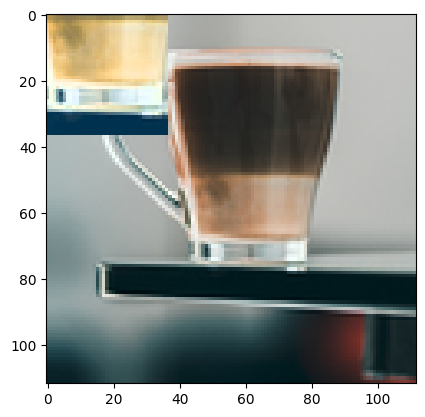

Episode: 0.225 Score: -13906.64, x: -34.92, y: -20.26
Episode: 0.250 Score: -15738.18, x: -17.18, y: -13.39
Episode: 0.275 Score: -17346.83, x: 31.62, y: 2.59
Episode: 0.300 Score: -18480.0, x: 49.23, y: 5.83
Episode: 0.325 Score: -19746.33, x: 65.32, y: 21.31
Episode: 0.350 Score: -21012.66, x: 58.45, y: 31.57
Episode: 0.375 Score: -22278.99, x: 57.63, y: 39.53
Episode: 0.400 Score: -23545.32, x: 36.36, y: 42.99


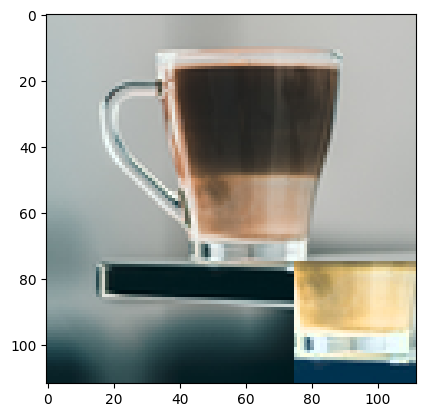

Episode: 0.425 Score: -24811.65, x: 34.5, y: 41.22
Episode: 0.450 Score: -26077.98, x: 21.31, y: 49.6
Episode: 0.475 Score: -27344.31, x: 15.7, y: 44.73
Episode: 0.500 Score: -28610.64, x: 26.43, y: 46.13
Episode: 0.525 Score: -29876.97, x: 12.41, y: 43.87
Episode: 0.550 Score: -31143.3, x: 6.41, y: 41.59
Episode: 0.575 Score: -32409.62, x: 12.34, y: 46.26
Episode: 0.600 Score: -33675.95, x: 14.73, y: 47.08


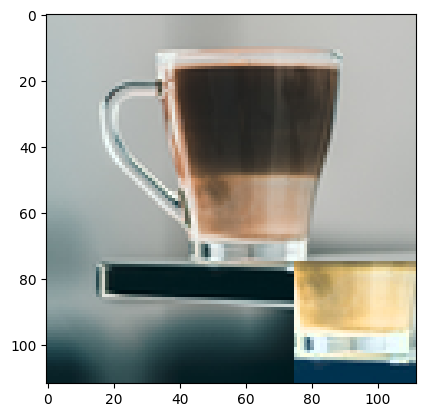

Episode: 0.625 Score: -34942.28, x: 6.25, y: 46.17
Episode: 0.650 Score: -35967.14, x: 3.11, y: 31.19
Episode: 0.675 Score: -37029.93, x: -18.18, y: 26.81
Episode: 0.700 Score: -38555.77, x: -28.67, y: 6.29
Episode: 0.725 Score: -40081.61, x: -27.01, y: 11.74
Episode: 0.750 Score: -41607.45, x: -17.65, y: 19.08
Episode: 0.775 Score: -43133.29, x: -19.94, y: 39.0
Episode: 0.800 Score: -44659.13, x: -19.4, y: 33.61


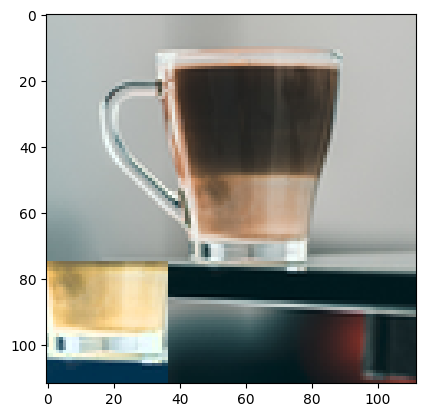

Episode: 0.825 Score: -46184.97, x: -28.49, y: 38.02
Episode: 0.850 Score: -47710.81, x: -23.59, y: 46.7
Episode: 0.875 Score: -49236.65, x: -16.8, y: 43.35
Episode: 0.900 Score: -50762.49, x: -17.55, y: 41.49
Episode: 0.925 Score: -52288.33, x: -6.14, y: 21.85
Episode: 0.950 Score: -53439.02, x: 13.4, y: 1.94
Episode: 0.975 Score: -54779.56, x: 29.63, y: -23.53
Episode: 0.1000 Score: -56409.13, x: 51.45, y: -43.47


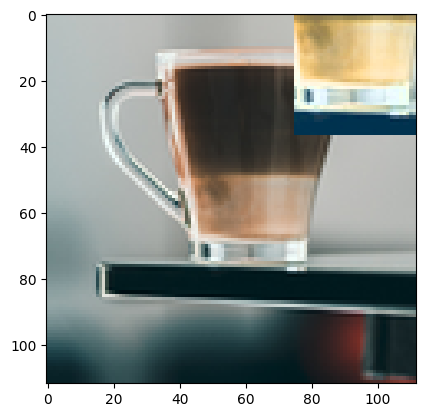

Episode: 0.1025 Score: -58038.7, x: 40.57, y: -41.5
Episode: 0.1050 Score: -59668.27, x: 33.14, y: -39.02
Episode: 0.1075 Score: -61297.84, x: 40.94, y: -23.95
Episode: 0.1100 Score: -62927.4, x: 49.85, y: -18.9
Episode: 0.1125 Score: -64556.97, x: 54.22, y: -14.19
Episode: 0.1150 Score: -66186.54, x: 67.18, y: -15.28
Episode: 0.1175 Score: -67816.11, x: 51.54, y: -24.17
Episode: 0.1200 Score: -69445.68, x: 42.93, y: -20.61


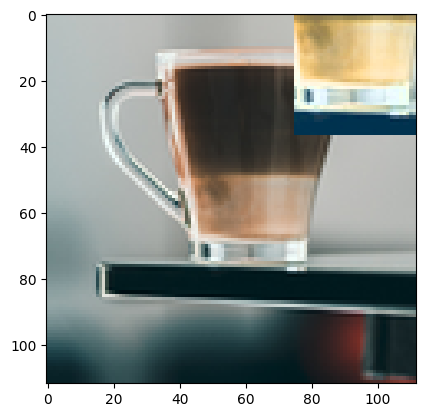

Episode: 0.1225 Score: -71075.25, x: 43.95, y: -14.65
Episode: 0.1250 Score: -72684.82, x: 53.7, y: -1.72
Episode: 0.1275 Score: -74264.39, x: 56.71, y: -4.44
Episode: 0.1300 Score: -75796.48, x: 52.04, y: -3.65
Episode: 0.1325 Score: -77426.05, x: 51.09, y: -6.94
Episode: 0.1350 Score: -79055.62, x: 45.79, y: -4.27
Episode: 0.1375 Score: -80508.65, x: 42.97, y: 1.29
Episode: 0.1400 Score: -82054.07, x: 39.78, y: -2.79


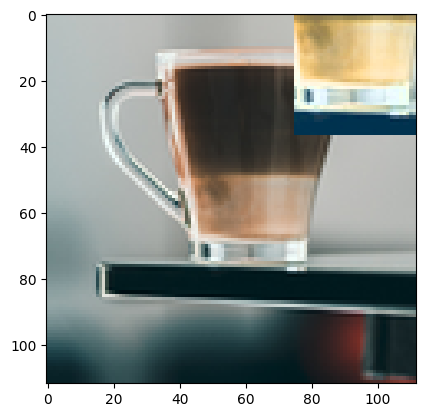

Episode: 0.1425 Score: -83683.64, x: 30.32, y: -17.49
Episode: 0.1450 Score: -85313.2, x: 19.59, y: -4.85
Episode: 0.1475 Score: -86851.2, x: 13.2, y: 0.54
Episode: 0.1500 Score: -87934.39, x: -1.46, y: 14.24
Episode: 0.1525 Score: -88645.65, x: -2.21, y: 2.16
Episode: 0.1550 Score: -89967.48, x: -7.5, y: 8.87
Episode: 0.1575 Score: -91493.32, x: -31.32, y: 14.36
Episode: 0.1600 Score: -93019.16, x: -39.03, y: 20.45


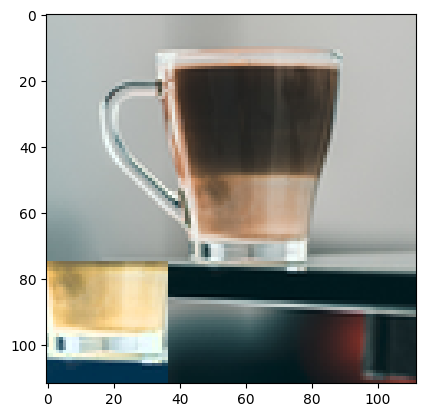

Episode: 0.1625 Score: -94545.0, x: -46.42, y: 26.32
Episode: 0.1650 Score: -96070.84, x: -45.99, y: 26.36
Episode: 0.1675 Score: -97596.68, x: -45.96, y: 15.64
Episode: 0.1700 Score: -99122.52, x: -48.95, y: 9.7
Episode: 0.1725 Score: -100648.36, x: -42.12, y: 12.93
Episode: 0.1750 Score: -102174.2, x: -32.38, y: 11.89
Episode: 0.1775 Score: -103700.04, x: -30.11, y: 20.69
Episode: 0.1800 Score: -105225.88, x: -29.0, y: 21.26


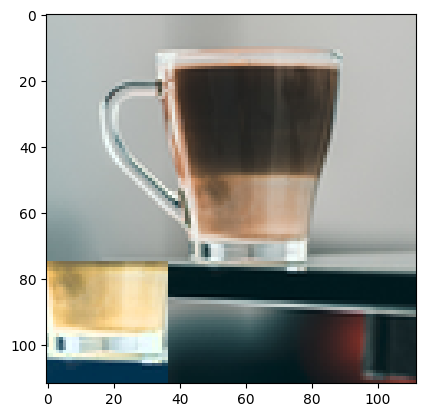

Episode: 0.1825 Score: -106751.72, x: -28.94, y: 25.73
Episode: 0.1850 Score: -108277.56, x: -29.27, y: 16.68
Episode: 0.1875 Score: -109803.4, x: -25.41, y: 12.25
Episode: 0.1900 Score: -111329.24, x: -26.98, y: 31.2
Episode: 0.1925 Score: -112855.08, x: -10.98, y: 35.42
Episode: 0.1950 Score: -114380.92, x: -16.19, y: 61.34
Episode: 0.1975 Score: -115906.76, x: -24.68, y: 49.54
Episode: 0.2000 Score: -117432.6, x: -25.1, y: 55.41


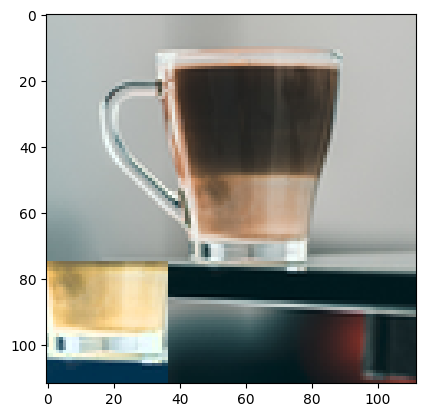

Episode: 0.2025 Score: -118958.45, x: -29.89, y: 70.35
Episode: 0.2050 Score: -120484.29, x: -21.83, y: 64.88
Episode: 0.2075 Score: -122010.13, x: -21.22, y: 69.49
Episode: 0.2100 Score: -123535.97, x: -9.97, y: 56.14
Episode: 0.2125 Score: -125061.81, x: -2.4, y: 48.68
Episode: 0.2150 Score: -126244.46, x: 8.48, y: 41.13
Episode: 0.2175 Score: -127510.79, x: 26.48, y: 48.77
Episode: 0.2200 Score: -128777.12, x: 53.64, y: 59.87


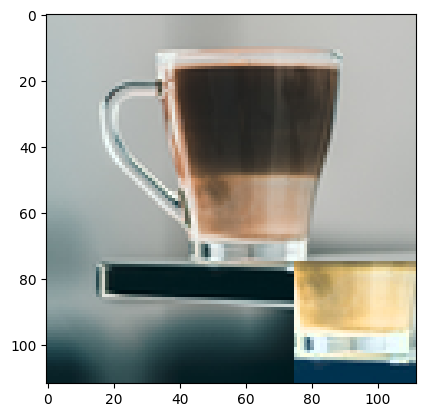

Episode: 0.2225 Score: -130043.45, x: 64.25, y: 72.84
Episode: 0.2250 Score: -131309.78, x: 66.09, y: 74.78
Episode: 0.2275 Score: -132576.11, x: 70.83, y: 76.47
Episode: 0.2300 Score: -133842.44, x: 86.94, y: 83.27
Episode: 0.2325 Score: -135108.77, x: 81.45, y: 76.92
Episode: 0.2350 Score: -136375.1, x: 83.73, y: 77.24
Episode: 0.2375 Score: -137641.43, x: 82.52, y: 80.99
Episode: 0.2400 Score: -138907.76, x: 94.0, y: 86.52


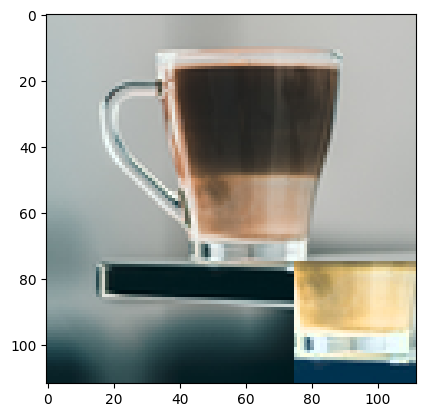

Episode: 0.2425 Score: -140174.09, x: 100.23, y: 89.72
Episode: 0.2450 Score: -141440.42, x: 104.66, y: 73.99
Episode: 0.2475 Score: -142706.75, x: 108.3, y: 64.28
Episode: 0.2500 Score: -143973.08, x: 104.71, y: 74.65
Episode: 0.2525 Score: -145239.41, x: 111.45, y: 64.14
Episode: 0.2550 Score: -146505.74, x: 99.66, y: 50.11
Episode: 0.2575 Score: -147772.07, x: 81.54, y: 48.06
Episode: 0.2600 Score: -149038.4, x: 87.8, y: 48.14


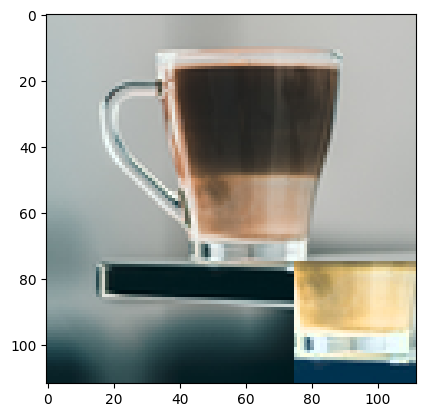

Episode: 0.2625 Score: -150304.73, x: 80.72, y: 60.62
Episode: 0.2650 Score: -151571.06, x: 76.17, y: 53.57
Episode: 0.2675 Score: -152837.39, x: 86.96, y: 46.95
Episode: 0.2700 Score: -154103.72, x: 90.43, y: 53.09
Episode: 0.2725 Score: -155370.05, x: 91.61, y: 61.58
Episode: 0.2750 Score: -156636.38, x: 91.21, y: 66.84
Episode: 0.2775 Score: -157902.71, x: 101.0, y: 76.44
Episode: 0.2800 Score: -159169.04, x: 106.36, y: 75.08


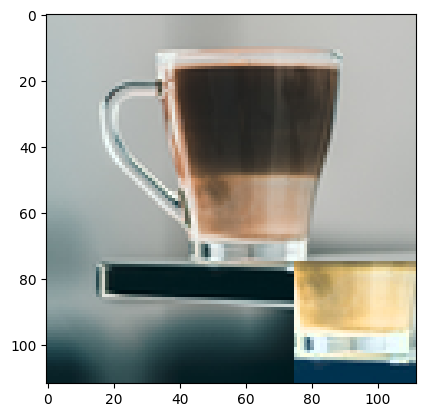

Episode: 0.2825 Score: -160435.37, x: 95.27, y: 77.73
Episode: 0.2850 Score: -161701.7, x: 94.86, y: 75.58
Episode: 0.2875 Score: -162968.03, x: 98.12, y: 77.27
Episode: 0.2900 Score: -164234.36, x: 100.1, y: 78.16
Episode: 0.2925 Score: -165500.69, x: 92.4, y: 91.95
Episode: 0.2950 Score: -166767.02, x: 102.13, y: 104.16
Episode: 0.2975 Score: -168033.35, x: 107.53, y: 99.37
Episode: 0.3000 Score: -169299.68, x: 106.87, y: 102.72


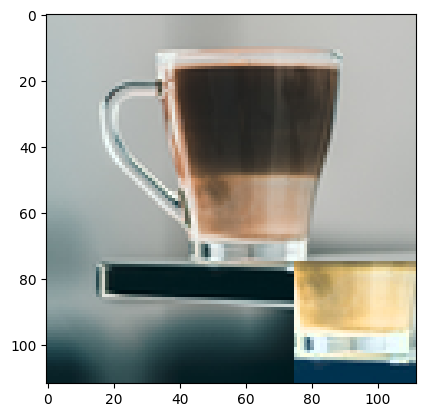

Episode: 0.3025 Score: -170566.01, x: 110.08, y: 104.13
Episode: 0.3050 Score: -171832.34, x: 104.11, y: 112.03
Episode: 0.3075 Score: -173098.67, x: 106.69, y: 103.15
Episode: 0.3100 Score: -174365.0, x: 110.24, y: 101.17
Episode: 0.3125 Score: -175631.33, x: 107.42, y: 96.2
Episode: 0.3150 Score: -176897.66, x: 112.49, y: 91.93
Episode: 0.3175 Score: -178163.99, x: 116.94, y: 96.69
Episode: 0.3200 Score: -179430.32, x: 111.37, y: 91.8


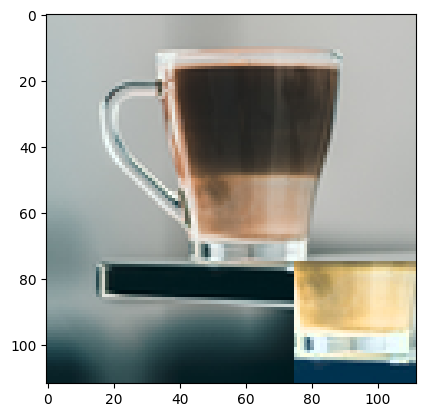

Episode: 0.3225 Score: -180696.65, x: 93.34, y: 66.04
Episode: 0.3250 Score: -181962.98, x: 89.34, y: 61.92
Episode: 0.3275 Score: -183229.31, x: 84.26, y: 58.3
Episode: 0.3300 Score: -184495.64, x: 86.99, y: 50.42
Episode: 0.3325 Score: -185761.97, x: 83.26, y: 42.4
Episode: 0.3350 Score: -187028.3, x: 89.9, y: 35.97
Episode: 0.3375 Score: -188294.63, x: 73.34, y: 37.33
Episode: 0.3400 Score: -189560.96, x: 75.02, y: 46.29


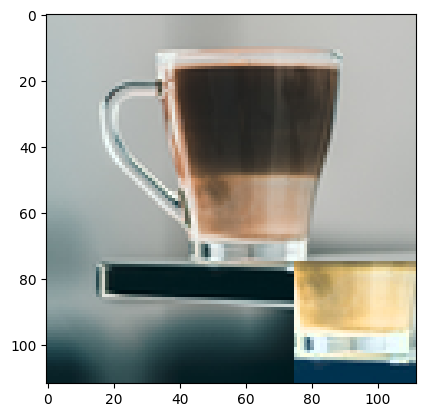

Episode: 0.3425 Score: -190827.29, x: 82.55, y: 43.88
Episode: 0.3450 Score: -192093.62, x: 87.63, y: 43.7
Episode: 0.3475 Score: -193359.95, x: 81.01, y: 45.29
Episode: 0.3500 Score: -194626.28, x: 80.42, y: 45.59
Episode: 0.3525 Score: -195892.61, x: 86.68, y: 65.83
Episode: 0.3550 Score: -197158.94, x: 76.46, y: 61.25
Episode: 0.3575 Score: -198425.27, x: 73.05, y: 66.76
Episode: 0.3600 Score: -199691.6, x: 79.39, y: 73.5


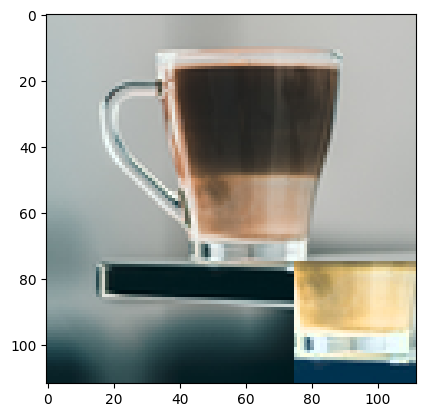

Episode: 0.3625 Score: -200957.93, x: 81.34, y: 91.03
Episode: 0.3650 Score: -202224.26, x: 83.16, y: 103.38
Episode: 0.3675 Score: -203490.59, x: 74.7, y: 115.93
Episode: 0.3700 Score: -204756.92, x: 58.86, y: 113.5
Episode: 0.3725 Score: -206023.25, x: 61.95, y: 113.61
Episode: 0.3750 Score: -207289.58, x: 54.35, y: 126.0
Episode: 0.3775 Score: -208555.91, x: 56.08, y: 140.38
Episode: 0.3800 Score: -209822.24, x: 71.81, y: 146.11


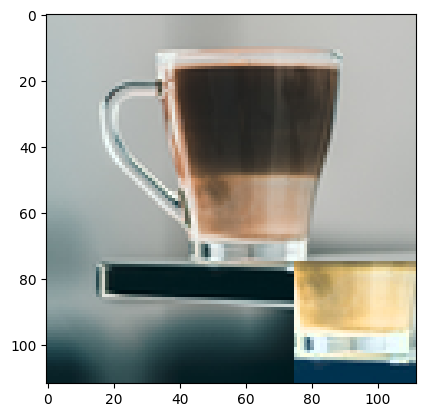

Episode: 0.3825 Score: -211088.57, x: 69.26, y: 138.48
Episode: 0.3850 Score: -212354.9, x: 68.95, y: 136.0
Episode: 0.3875 Score: -213621.22, x: 81.54, y: 125.19
Episode: 0.3900 Score: -214887.55, x: 77.52, y: 116.99
Episode: 0.3925 Score: -216153.88, x: 61.79, y: 110.76
Episode: 0.3950 Score: -217420.21, x: 46.23, y: 109.41
Episode: 0.3975 Score: -218686.54, x: 43.62, y: 107.78
Episode: 0.4000 Score: -219952.87, x: 32.24, y: 99.76


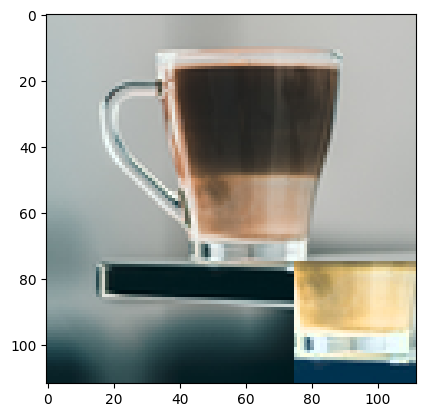

Episode: 0.4025 Score: -221219.2, x: 49.21, y: 96.3
Episode: 0.4050 Score: -222485.53, x: 54.56, y: 101.25
Episode: 0.4075 Score: -223751.86, x: 45.81, y: 99.66
Episode: 0.4100 Score: -225018.19, x: 50.4, y: 95.52
Episode: 0.4125 Score: -226284.52, x: 38.42, y: 95.58
Episode: 0.4150 Score: -227550.85, x: 26.93, y: 97.1
Episode: 0.4175 Score: -228817.18, x: 25.22, y: 98.24
Episode: 0.4200 Score: -230083.51, x: 26.24, y: 105.47


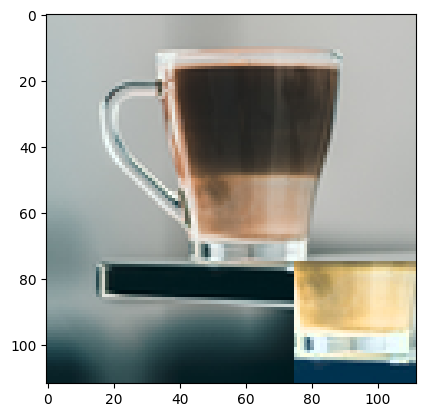

Episode: 0.4225 Score: -231349.84, x: 44.94, y: 125.91
Episode: 0.4250 Score: -232616.17, x: 46.06, y: 127.83
Episode: 0.4275 Score: -233882.5, x: 31.52, y: 136.42
Episode: 0.4300 Score: -235148.83, x: 28.07, y: 142.75
Episode: 0.4325 Score: -236415.16, x: 8.98, y: 153.76
Episode: 0.4350 Score: -237671.49, x: 7.87, y: 160.3
Episode: 0.4375 Score: -238854.4, x: -19.26, y: 126.27
Episode: 0.4400 Score: -239855.23, x: -26.78, y: 140.12


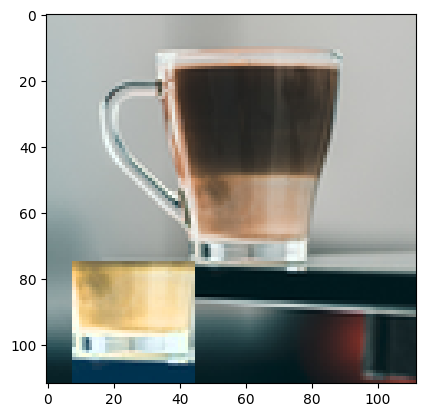

Episode: 0.4425 Score: -240757.64, x: -2.14, y: 161.26
Episode: 0.4450 Score: -241670.95, x: -2.55, y: 154.47
Episode: 0.4475 Score: -242662.65, x: -8.56, y: 163.34
Episode: 0.4500 Score: -243794.64, x: 20.88, y: 169.17
Episode: 0.4525 Score: -244722.89, x: -16.97, y: 117.24
Episode: 0.4550 Score: -245624.97, x: -30.54, y: 128.0
Episode: 0.4575 Score: -246528.8, x: 30.48, y: 176.03
Episode: 0.4600 Score: -247425.97, x: -18.87, y: 127.59


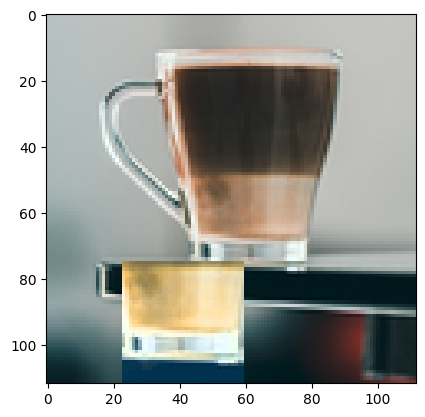

Episode: 0.4625 Score: -248144.64, x: 2.73, y: 141.14
Episode: 0.4650 Score: -248838.35, x: 6.63, y: 150.34
Episode: 0.4675 Score: -249969.58, x: 51.06, y: 176.39
Episode: 0.4700 Score: -251235.91, x: 51.46, y: 154.12
Episode: 0.4725 Score: -252502.24, x: 59.21, y: 148.48
Episode: 0.4750 Score: -253768.57, x: 59.53, y: 151.73
Episode: 0.4775 Score: -255034.9, x: 78.11, y: 160.23
Episode: 0.4800 Score: -256301.23, x: 67.42, y: 150.24


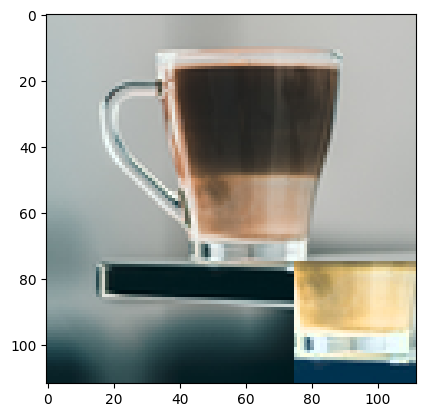

Episode: 0.4825 Score: -257567.56, x: 71.83, y: 144.61
Episode: 0.4850 Score: -258833.89, x: 65.15, y: 135.9
Episode: 0.4875 Score: -260100.22, x: 63.45, y: 124.67
Episode: 0.4900 Score: -261366.55, x: 57.09, y: 128.92
Episode: 0.4925 Score: -262632.88, x: 64.01, y: 117.29
Episode: 0.4950 Score: -263899.21, x: 74.32, y: 139.97
Episode: 0.4975 Score: -265165.54, x: 90.31, y: 141.76
Episode: 0.5000 Score: -266431.87, x: 88.64, y: 141.65


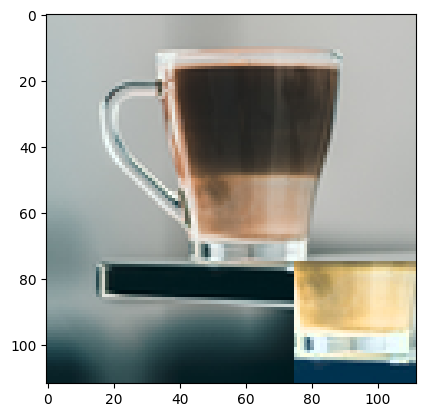

Episode: 0.5025 Score: -267698.2, x: 96.96, y: 123.59
Episode: 0.5050 Score: -268964.53, x: 90.99, y: 122.22
Episode: 0.5075 Score: -270230.86, x: 95.16, y: 117.87
Episode: 0.5100 Score: -271497.19, x: 89.11, y: 122.17
Episode: 0.5125 Score: -272763.52, x: 85.03, y: 121.13
Episode: 0.5150 Score: -274029.85, x: 98.72, y: 113.62
Episode: 0.5175 Score: -275296.18, x: 99.79, y: 108.4
Episode: 0.5200 Score: -276562.51, x: 97.85, y: 112.21


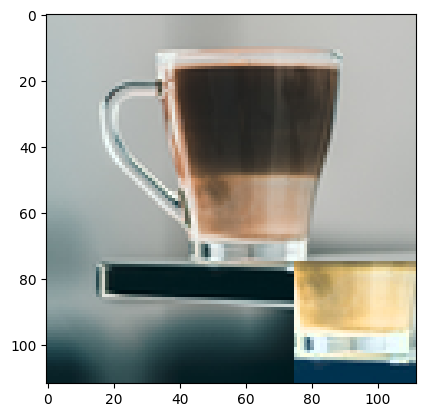

Episode: 0.5225 Score: -277828.84, x: 94.11, y: 107.43
Episode: 0.5250 Score: -279095.17, x: 94.16, y: 115.05
Episode: 0.5275 Score: -280361.5, x: 104.55, y: 112.62
Episode: 0.5300 Score: -281627.83, x: 95.26, y: 104.48
Episode: 0.5325 Score: -282894.16, x: 103.97, y: 111.62
Episode: 0.5350 Score: -284160.49, x: 121.87, y: 111.98
Episode: 0.5375 Score: -285426.82, x: 124.98, y: 126.19
Episode: 0.5400 Score: -286693.15, x: 113.94, y: 131.63


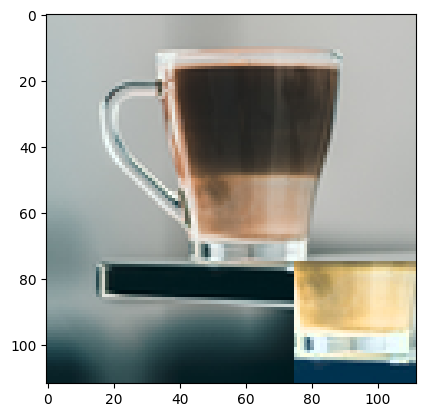

Episode: 0.5425 Score: -287959.48, x: 106.71, y: 135.77
Episode: 0.5450 Score: -289225.81, x: 117.39, y: 128.96
Episode: 0.5475 Score: -290492.14, x: 96.28, y: 133.4
Episode: 0.5500 Score: -291758.47, x: 92.65, y: 120.49
Episode: 0.5525 Score: -293024.8, x: 101.39, y: 114.95
Episode: 0.5550 Score: -294291.13, x: 89.13, y: 113.96
Episode: 0.5575 Score: -295557.46, x: 84.79, y: 111.65
Episode: 0.5600 Score: -296823.79, x: 95.35, y: 112.87


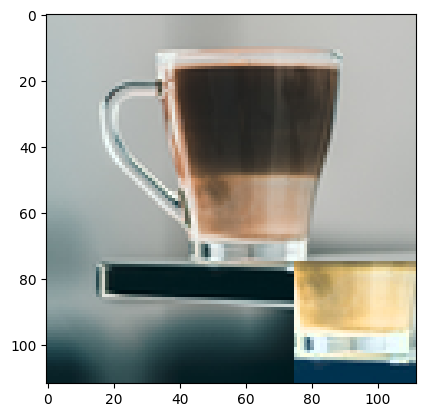

Episode: 0.5625 Score: -298090.12, x: 92.38, y: 117.71
Episode: 0.5650 Score: -299356.45, x: 86.2, y: 133.96
Episode: 0.5675 Score: -300622.78, x: 91.8, y: 140.67
Episode: 0.5700 Score: -301889.11, x: 99.1, y: 124.62
Episode: 0.5725 Score: -303155.44, x: 74.02, y: 131.4
Episode: 0.5750 Score: -304421.77, x: 73.9, y: 115.5
Episode: 0.5775 Score: -305688.1, x: 67.69, y: 101.37
Episode: 0.5800 Score: -306954.43, x: 60.91, y: 112.69


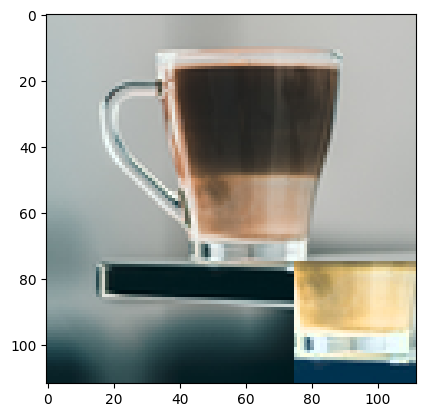

Episode: 0.5825 Score: -308220.76, x: 63.67, y: 117.84
Episode: 0.5850 Score: -309487.09, x: 67.0, y: 132.21
Episode: 0.5875 Score: -310753.42, x: 70.27, y: 126.54
Episode: 0.5900 Score: -312019.75, x: 52.01, y: 127.01
Episode: 0.5925 Score: -313286.08, x: 54.79, y: 118.98
Episode: 0.5950 Score: -314552.41, x: 63.76, y: 101.99
Episode: 0.5975 Score: -315818.74, x: 58.59, y: 101.43
Episode: 0.6000 Score: -317085.07, x: 72.65, y: 98.21


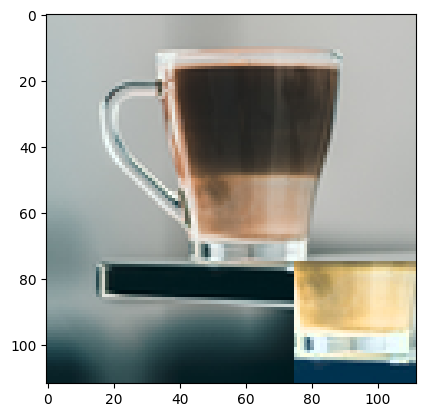

Episode: 0.6025 Score: -318351.4, x: 74.72, y: 83.0
Episode: 0.6050 Score: -319617.73, x: 60.13, y: 68.47
Episode: 0.6075 Score: -320884.06, x: 53.73, y: 85.58
Episode: 0.6100 Score: -322150.39, x: 41.19, y: 76.6
Episode: 0.6125 Score: -323416.72, x: 35.09, y: 82.38
Episode: 0.6150 Score: -324683.05, x: 39.74, y: 107.77
Episode: 0.6175 Score: -325949.38, x: 46.25, y: 110.28
Episode: 0.6200 Score: -327215.71, x: 47.43, y: 109.57


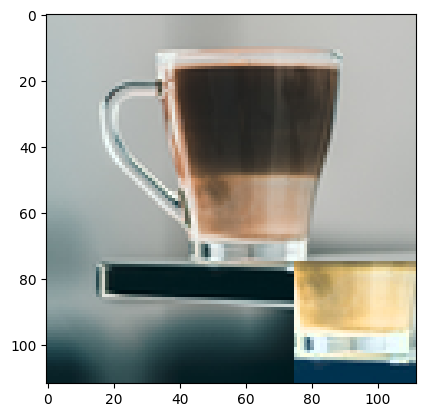

Episode: 0.6225 Score: -328482.04, x: 47.46, y: 108.64
Episode: 0.6250 Score: -329748.37, x: 63.53, y: 105.49
Episode: 0.6275 Score: -331014.7, x: 58.02, y: 108.16
Episode: 0.6300 Score: -332281.03, x: 70.66, y: 96.31
Episode: 0.6325 Score: -333547.36, x: 69.71, y: 102.53
Episode: 0.6350 Score: -334813.69, x: 70.44, y: 101.76
Episode: 0.6375 Score: -336080.02, x: 78.31, y: 110.36
Episode: 0.6400 Score: -337346.35, x: 70.95, y: 96.0


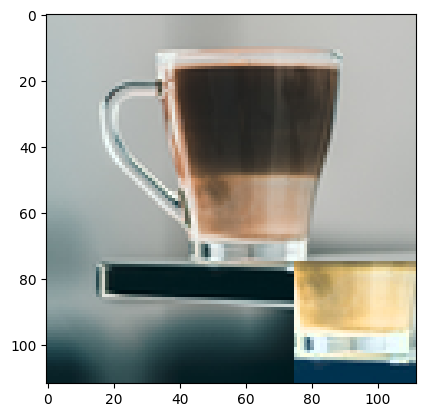

Episode: 0.6425 Score: -338612.68, x: 76.8, y: 92.97
Episode: 0.6450 Score: -339879.01, x: 67.79, y: 89.03
Episode: 0.6475 Score: -341145.34, x: 75.54, y: 96.55
Episode: 0.6500 Score: -342411.67, x: 66.25, y: 103.75
Episode: 0.6525 Score: -343678.0, x: 69.1, y: 98.22
Episode: 0.6550 Score: -344944.33, x: 62.73, y: 103.36
Episode: 0.6575 Score: -346210.66, x: 69.04, y: 108.43
Episode: 0.6600 Score: -347476.99, x: 73.09, y: 108.18


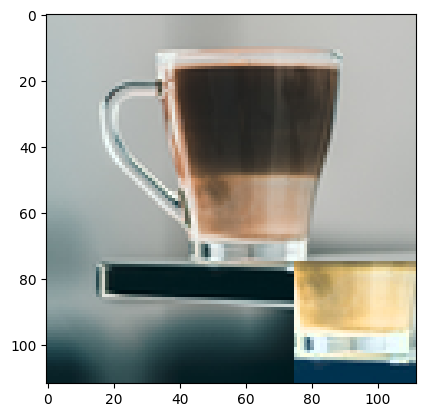

Episode: 0.6625 Score: -348743.32, x: 65.4, y: 100.17
Episode: 0.6650 Score: -350009.65, x: 64.01, y: 94.41
Episode: 0.6675 Score: -351275.98, x: 66.52, y: 106.63
Episode: 0.6700 Score: -352542.31, x: 58.09, y: 113.62
Episode: 0.6725 Score: -353808.64, x: 53.25, y: 119.02
Episode: 0.6750 Score: -355074.97, x: 55.96, y: 102.32
Episode: 0.6775 Score: -356341.3, x: 52.24, y: 95.81
Episode: 0.6800 Score: -357607.63, x: 52.94, y: 104.36


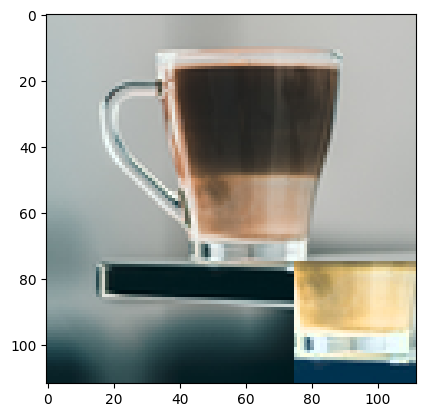

Episode: 0.6825 Score: -358873.96, x: 45.8, y: 109.52
Episode: 0.6850 Score: -360140.29, x: 37.57, y: 109.29
Episode: 0.6875 Score: -361406.62, x: 30.08, y: 110.21
Episode: 0.6900 Score: -362672.95, x: 37.33, y: 123.33
Episode: 0.6925 Score: -363939.28, x: 39.01, y: 125.81
Episode: 0.6950 Score: -365205.61, x: 39.84, y: 127.63
Episode: 0.6975 Score: -366471.93, x: 45.62, y: 130.5
Episode: 0.7000 Score: -367738.26, x: 42.32, y: 128.22


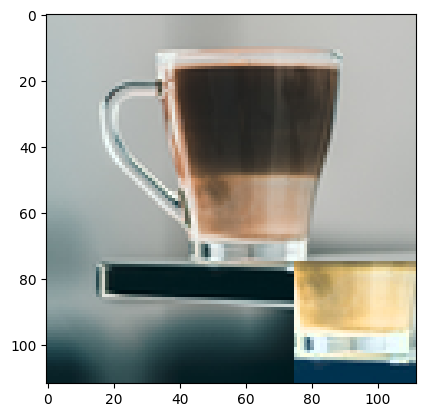

Episode: 0.7025 Score: -369004.59, x: 53.49, y: 121.68
Episode: 0.7050 Score: -370270.92, x: 51.51, y: 138.2
Episode: 0.7075 Score: -371537.25, x: 59.98, y: 140.61
Episode: 0.7100 Score: -372803.58, x: 61.5, y: 139.47
Episode: 0.7125 Score: -374069.91, x: 58.06, y: 131.22
Episode: 0.7150 Score: -375336.24, x: 47.1, y: 123.42
Episode: 0.7175 Score: -376602.57, x: 39.01, y: 123.38
Episode: 0.7200 Score: -377868.9, x: 31.0, y: 129.21


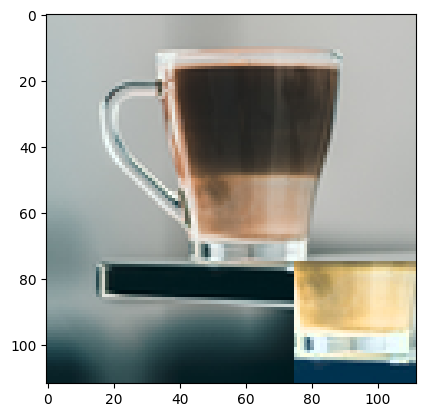

Episode: 0.7225 Score: -379135.23, x: 13.68, y: 110.94
Episode: 0.7250 Score: -380401.56, x: 23.97, y: 111.04
Episode: 0.7275 Score: -381667.89, x: 11.24, y: 112.77
Episode: 0.7300 Score: -382934.22, x: 8.09, y: 111.41
Episode: 0.7325 Score: -384190.55, x: 5.74, y: 106.82
Episode: 0.7350 Score: -385332.85, x: 15.73, y: 111.19
Episode: 0.7375 Score: -386330.12, x: 13.07, y: 108.7
Episode: 0.7400 Score: -387375.66, x: 8.96, y: 96.0


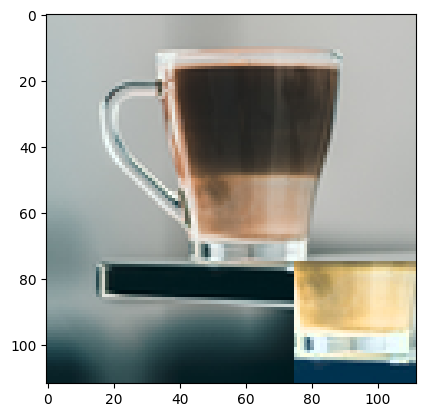

Episode: 0.7425 Score: -388448.31, x: 12.86, y: 87.49
Episode: 0.7450 Score: -389544.99, x: 3.28, y: 97.59
Episode: 0.7475 Score: -390613.86, x: -5.78, y: 99.92
Episode: 0.7500 Score: -391456.25, x: 1.05, y: 104.32
Episode: 0.7525 Score: -392203.81, x: 1.49, y: 91.55
Episode: 0.7550 Score: -393026.81, x: 9.45, y: 100.85
Episode: 0.7575 Score: -393837.43, x: 3.57, y: 104.83
Episode: 0.7600 Score: -394595.46, x: -5.53, y: 92.53


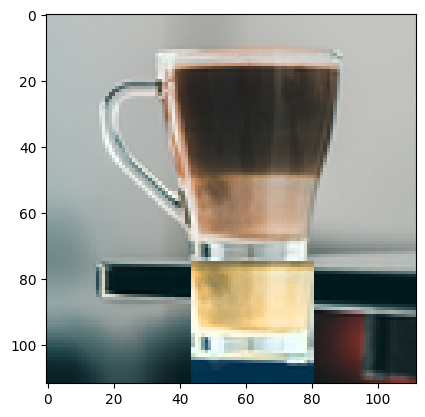

Episode: 0.7625 Score: -395366.02, x: -3.05, y: 81.55
Episode: 0.7650 Score: -396078.23, x: -7.44, y: 80.89
Episode: 0.7675 Score: -396843.91, x: 8.98, y: 74.7
Episode: 0.7700 Score: -397534.98, x: -14.16, y: 98.92
Episode: 0.7725 Score: -398239.87, x: 9.31, y: 85.69
Episode: 0.7750 Score: -398941.5, x: -3.68, y: 86.08
Episode: 0.7775 Score: -399628.56, x: -8.25, y: 81.56
Episode: 0.7800 Score: -400307.69, x: -10.0, y: 82.71


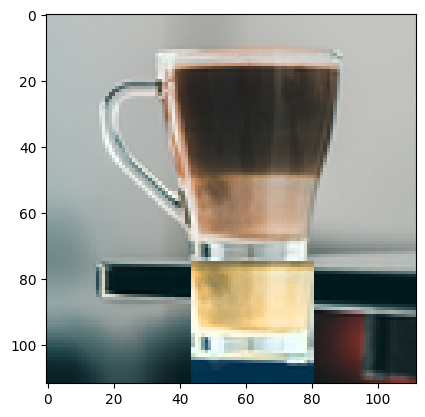

Episode: 0.7825 Score: -401011.79, x: 26.2, y: 86.1
Episode: 0.7850 Score: -401840.98, x: 22.09, y: 81.47
Episode: 0.7875 Score: -402637.73, x: -1.61, y: 81.53
Episode: 0.7900 Score: -403389.64, x: -2.77, y: 58.24
Episode: 0.7925 Score: -404139.87, x: 5.37, y: 39.33
Episode: 0.7950 Score: -404885.68, x: -8.79, y: 47.23
Episode: 0.7975 Score: -405634.27, x: -3.43, y: 29.97
Episode: 0.8000 Score: -406418.19, x: 1.66, y: 20.11


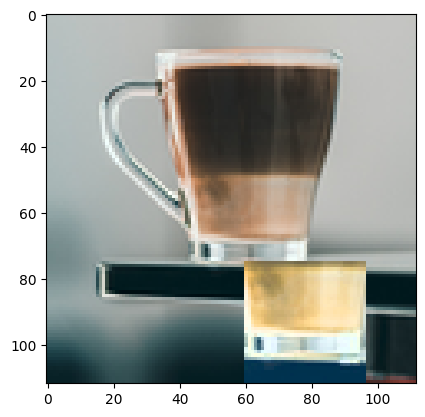

Episode: 0.8025 Score: -407187.43, x: 0.73, y: 32.64
Episode: 0.8050 Score: -408040.54, x: -7.65, y: 114.58
Episode: 0.8075 Score: -408811.29, x: -6.71, y: 66.85
Episode: 0.8100 Score: -409508.31, x: 3.73, y: 48.98
Episode: 0.8125 Score: -410205.22, x: -2.9, y: 29.86
Episode: 0.8150 Score: -410897.12, x: -1.26, y: 40.93
Episode: 0.8175 Score: -411607.94, x: 1.71, y: 39.46
Episode: 0.8200 Score: -412289.77, x: -1.05, y: 62.09


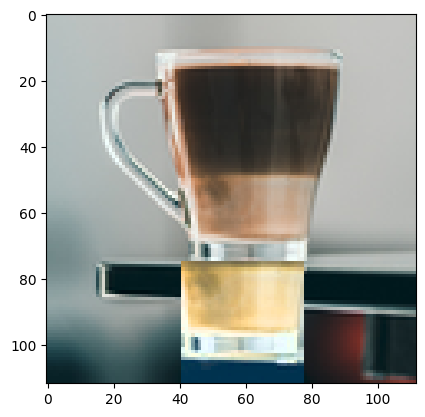

Episode: 0.8225 Score: -412966.24, x: -0.68, y: 18.11
Episode: 0.8250 Score: -413677.06, x: -6.99, y: 31.04
Episode: 0.8275 Score: -414457.48, x: 4.86, y: 91.27
Episode: 0.8300 Score: -415215.52, x: 12.7, y: 89.82
Episode: 0.8325 Score: -415924.44, x: 0.62, y: 37.83
Episode: 0.8350 Score: -416601.08, x: 0.25, y: 19.18
Episode: 0.8375 Score: -417301.48, x: 23.7, y: 81.69
Episode: 0.8400 Score: -418028.53, x: -8.92, y: 37.88


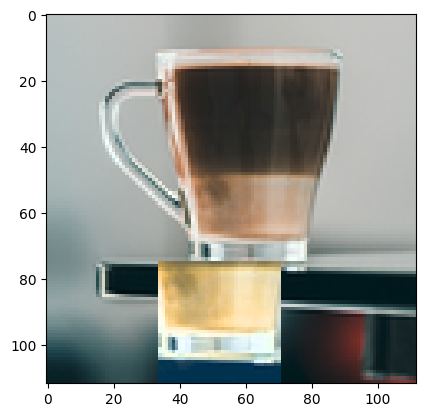

Episode: 0.8425 Score: -418780.68, x: -22.77, y: 24.53
Episode: 0.8450 Score: -419616.29, x: -6.54, y: 107.3
Episode: 0.8475 Score: -420584.5, x: -4.17, y: 66.61
Episode: 0.8500 Score: -421366.79, x: -7.54, y: 61.85
Episode: 0.8525 Score: -422157.08, x: -4.11, y: 89.43
Episode: 0.8550 Score: -422899.29, x: 11.48, y: 112.58
Episode: 0.8575 Score: -423616.14, x: -7.65, y: 25.98
Episode: 0.8600 Score: -424316.32, x: -5.83, y: 20.12


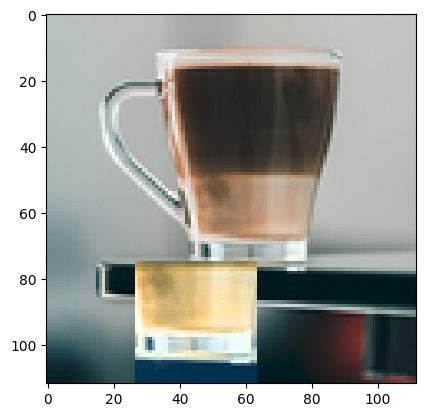

Episode: 0.8625 Score: -425028.66, x: -1.01, y: 54.35
Episode: 0.8650 Score: -425794.79, x: -7.91, y: 40.71
Episode: 0.8675 Score: -426585.56, x: 11.6, y: 91.31
Episode: 0.8700 Score: -427267.59, x: -13.56, y: 89.32
Episode: 0.8725 Score: -427966.5, x: -2.41, y: 37.4
Episode: 0.8750 Score: -428660.22, x: -10.11, y: 17.78
Episode: 0.8775 Score: -429353.38, x: -11.49, y: -0.06
Episode: 0.8800 Score: -429877.09, x: -21.42, y: 10.6


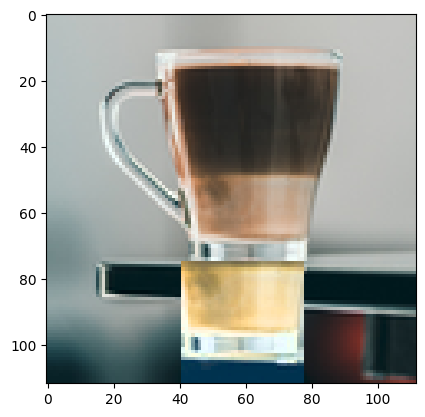

Episode: 0.8825 Score: -430568.3, x: 14.47, y: 42.59
Episode: 0.8850 Score: -431264.63, x: -3.88, y: 16.97
Episode: 0.8875 Score: -431977.66, x: 3.79, y: 47.87
Episode: 0.8900 Score: -432699.64, x: -0.22, y: 34.25
Episode: 0.8925 Score: -433383.62, x: 5.69, y: 35.69
Episode: 0.8950 Score: -434099.86, x: 4.93, y: 94.16
Episode: 0.8975 Score: -434813.1, x: -8.59, y: 98.78
Episode: 0.9000 Score: -435498.92, x: 9.47, y: 34.43


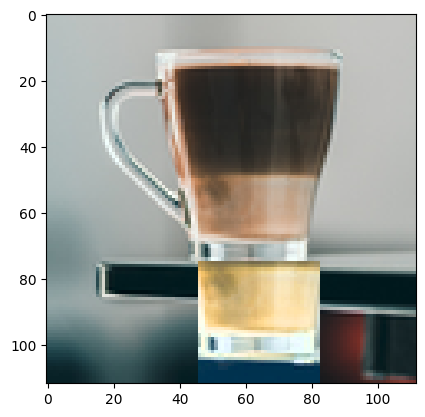

Episode: 0.9025 Score: -436189.22, x: -17.18, y: 42.29
Episode: 0.9050 Score: -436891.82, x: 7.25, y: 34.94
Episode: 0.9075 Score: -437587.38, x: -10.07, y: 82.4
Episode: 0.9100 Score: -438199.3, x: 0.39, y: 10.08


KeyboardInterrupt: 

In [117]:
# from ddpg_torch import Agent
# import gym
import numpy as np
# from utils import plotLearning

# env = gym.make('LunarLanderContinuous-v2')
env = envs[0]
agent = Agent(alpha=0.000025, beta=0.00025, input_dims=[3,112,112], tau=0.001, env=env,
              batch_size=64,  layer1_size=400, layer2_size=300, n_actions=2)

#agent.load_models()
np.random.seed(0)

score_history = []
for i in range(1000):
    obs = env.reset()
    done = False
    score = 0
    t = 0
    while not done:
        t += 1
        act = agent.choose_action(obs)
        new_state, reward, done = env.step(act)
        agent.remember(transform_obs(obs), act, reward, transform_obs(new_state), int(done))
        agent.learn()
        score += reward
        obs = new_state
        if t%25 == 0:
            x_amount = act[0][0]*env.fixed_image.size[0]
            y_amount = act[0][1]*env.fixed_image.size[1]
            print(f'Episode: {i}.{t} Score: {score.round(2)}, x: {x_amount.round(2)}, y: {y_amount.round(2)}')
            # plot the state
        if t%200 == 0:
            # plot the state
            plt.imshow(obs)
            plt.show()
            
        #env.render()
    score_history.append(score)

    #if i % 25 == 0:
    #    agent.save_models()

    print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history[-100:]))

filename = 'LunarLander-alpha000025-beta00025-400-300.png'
plotLearning(score_history, filename, window=100)